In [1]:
import pandas as pd
import numpy as np, os
import matplotlib.pyplot as plt

from pathlib import Path

import gbd_mapping as gm
from vivarium import Artifact

from db_queries import get_ids, get_outputs, get_population, get_covariate_estimates
from get_draws.api import get_draws

!date
!whoami
!pwd

Mon Sep 15 20:15:17 PDT 2025
abie
/mnt/share/homes/abie/notebook/2025


## V&V List from Docs 

    - Verify that all simulants in the model have AD (i.e., all recorded person-time is in one of the “AD” states, not the “susceptible” state)
    - Verify that there are simulant person-years of BBBM-AD, MCI-AD, and AD-dementia for every year and age group of simulation
    - Verify that there are transitions between AD states are at the expected rates
    - Verify other sim mortality against artifact (ACMR - CSMR)
    - Verify Alzheimer’s EMR against artifact
    - Verify the number of new AD-demential cases per year against the AD population model

# Load Data

In [5]:
%cd /mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/

/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers


In [9]:
locations = ['united_states_of_america',
#              'china',
#              'brazil',
#              'japan',
#              'sweden',
#              'united_kingdom',
            ]



results_dirs = [
    'results/model4.2/united_states_of_america/2025_09_16_11_40_47/results/',
]

artifact_dirs = ['artifacts/model4.2/' + x + '.hdf' for x in locations]
artifact_dirs

['artifacts/model4.2/united_states_of_america.hdf']

In [11]:
[x for x in os.listdir(results_dirs[0]) if 'parquet' in x]

['deaths.parquet',
 'ylls.parquet',
 'new_simulants.parquet',
 'transition_count_alzheimers_disease_and_other_dementias.parquet',
 'ylds.parquet',
 'person_time_alzheimers_disease_and_other_dementias.parquet']

In [54]:
age_group_ids = [11,12,13,14,15,16,17,18,19,20,30,31,32,33]
art = Artifact(artifact_dirs[0],
               filter_terms = ['year_start==2021']  # FIXME: make this work even without filter_terms
              )

age_dictionary = pd.DataFrame()
age_dictionary['age_group_id'] = age_group_ids
age_dictionary = age_dictionary.merge(get_ids('age_group'), on='age_group_id')
age_dictionary['age_group'] = age_dictionary.age_group_name.str.lower().str.replace(' ', '_')
artifact = art.load('population.structure').reset_index()
artifact = artifact.loc[artifact.age_start > 29].reset_index()
age_dictionary['age_start'] = artifact.age_start
age_dictionary['age_end'] = artifact.age_end

# tweak final row to be named age group 95_plus
assert age_dictionary.loc[13, 'age_group'] == '95_to_99'
age_dictionary.loc[13, 'age_group'] = '95_plus'

age_dictionary.tail()

,age_group_id,age_group_name,age_group,age_start,age_end
9,20,75 to 79,75_to_79,75.0,80.0
10,30,80 to 84,80_to_84,80.0,85.0
11,31,85 to 89,85_to_89,85.0,90.0
12,32,90 to 94,90_to_94,90.0,95.0
13,33,95 to 99,95_plus,95.0,125.0


## Verify that all simulants in the model have AD 

In [55]:
def load_df(measure):
    data = pd.DataFrame()
    for results_dir in results_dirs:
        temp = pd.read_parquet(results_dir + measure + '.parquet')
        
        # aggregate by summing value column over random seeds
        cols = [c for c in temp.columns if c not in ['value', 'random_seed']]
        temp = temp.groupby(cols)['value'].sum().reset_index()
        
        temp['location'] = locations[results_dirs.index(results_dir)].title()
        temp['current_year'] = temp['current_year'].astype(int)
        data = pd.concat([data, temp], ignore_index=True)
    return data

In [56]:
person_time = load_df('person_time_alzheimers_disease_and_other_dementias')
person_time.loc[person_time.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias'].value.sum()

0.0

In [57]:
assert person_time.loc[person_time.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias'].value.sum() == 0, \
       'should be zero years of person-time susceptible'

# Verify that there *are* simulants in BBBM-AD and MCI-AD for all ages and years

In [58]:
person_time.groupby('sub_entity').value.sum()

sub_entity
alzheimers_blood_based_biomarker_state        2.088568e+08
alzheimers_disease_state                      2.580444e+08
alzheimers_mild_cognitive_impairment_state    1.105167e+08
Name: value, dtype: float64

In [59]:
person_time.groupby(['location', 'current_year', 'age_group', 'sub_entity']).value.sum().unstack()

sub_entity                                       alzheimers_blood_based_biomarker_state  \
location                 current_year age_group                                           
United_States_Of_America 2025         25_to_29                                 4.008214   
                                      30_to_34                              4050.800821   
                                      35_to_39                              4442.102669   
                                      40_to_44                              4252.714579   
                                      45_to_49                             13685.043121   
...                                                                                 ...   
                         2100         75_to_79                            367469.010267   
                                      80_to_84                            426456.386037   
                                      85_to_89                            400257.199179   
                                      90_to_94                            473783.868583   
                                      95_plus                             664244.156057   

sub_entity                                       alzheimers_disease_state  \
location                 current_year age_group                             
United_States_Of_America 2025         25_to_29                   0.000000   
                                      30_to_34                 160.328542   
                                      35_to_39                 177.864476   
                                      40_to_44                 155.819302   
                                      45_to_49                 562.151951   
...                                                                   ...   
                         2100         75_to_79              433321.453799   
                                      80_to_84              608079.063655   
                                      85_to_89              659256.936345   
                                      90_to_94              663405.938398   
                                      95_plus               853601.683778   

sub_entity                                       alzheimers_mild_cognitive_impairment_state  
location                 current_year age_group                                              
United_States_Of_America 2025         25_to_29                                     2.505133  
                                      30_to_34                                  2371.860370  
                                      35_to_39                                  2639.909651  
                                      40_to_44                                  2554.234086  
                                      45_to_49                                  8015.425051  
...                                                                                     ...  
                         2100         75_to_79                                192403.268994  
                                      80_to_84                                225267.112936  
                                      85_to_89                                212937.347023  
                                      90_to_94                                255338.735113  
                                      95_plus                                 349709.117043  

[1140 rows x 3 columns]

In [60]:
assert np.all(person_time.groupby(['location', 'current_year', 'age_group', 'sub_entity']).value.sum().unstack().fillna(0) > 0)

AssertionError: 

## Verify that there are no transitions out of susceptible state during the simulation 

In [61]:
trans = load_df('transition_count_alzheimers_disease_and_other_dementias')
trans.loc[trans.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias'].value.sum()

0.0

In [62]:
assert trans.loc[trans.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias'].value.sum() == 0, \
       'should be zero transitions from susceptible to with-condition'

# And that there *are* transitions out of other states for all ages

In [63]:
assert np.all(trans.groupby(['location', 'current_year', 'age_group', 'sub_entity']).value.sum().unstack() > 0)

AssertionError: 

## Next look at the transition rates and approximate durations for BBBM and MCI

In [64]:
out_counts = trans.groupby(['location', 'current_year', 'age_group', 'sub_entity']).value.sum().unstack()
out_counts.columns = [c.split('_to_')[0] for c in out_counts.columns]
out_counts

alzheimers_blood_based_biomarker_state  \
location                 current_year age_group                                           
United_States_Of_America 2025         25_to_29                                      0.0   
                                      30_to_34                                    262.0   
                                      35_to_39                                    362.0   
                                      40_to_44                                    314.0   
                                      45_to_49                                    889.0   
...                                                                                 ...   
                         2100         75_to_79                                  28030.0   
                                      80_to_84                                  34321.0   
                                      85_to_89                                  32588.0   
                                      90_to_94                                  32412.0   
                                      95_plus                                   49233.0   

                                                 alzheimers_mild_cognitive_impairment_state  
location                 current_year age_group                                              
United_States_Of_America 2025         25_to_29                                          2.0  
                                      30_to_34                                        577.0  
                                      35_to_39                                        688.0  
                                      40_to_44                                        655.0  
                                      45_to_49                                       1930.0  
...                                                                                     ...  
                         2100         75_to_79                                      47539.0  
                                      80_to_84                                      56565.0  
                                      85_to_89                                      53573.0  
                                      90_to_94                                      59198.0  
                                      95_plus                                       85679.0  

[1140 rows x 2 columns]

In [65]:
out_rates = out_counts / person_time.groupby(['location', 'current_year', 'age_group', 'sub_entity']).value.sum().unstack()
out_rates['alzheimers_blood_based_biomarker_state'].unstack()

age_group                              25_to_29  30_to_34  35_to_39  40_to_44  \
location                 current_year                                           
United_States_Of_America 2025          0.000000  0.064679  0.081493  0.073835   
                         2026          0.142564  0.065836  0.075677  0.069272   
                         2027          0.000000  0.060115  0.072265  0.071936   
                         2028          0.034412  0.060588  0.077481  0.070620   
                         2029          0.122825  0.040600  0.076195  0.071413   
...                                         ...       ...       ...       ...   
                         2096          0.120964  0.063456  0.067181  0.069552   
                         2097          0.090723  0.066977  0.067283  0.072177   
                         2098          0.117406  0.058673  0.062357  0.068953   
                         2099          0.036289  0.059264  0.065881  0.068002   
                         2100          0.092119  0.056421  0.060888  0.071580   

age_group                              45_to_49  50_to_54  55_to_59  60_to_64  \
location                 current_year                                           
United_States_Of_America 2025          0.064961  0.067252  0.070294  0.068758   
                         2026          0.068992  0.071315  0.072759  0.069731   
                         2027          0.070159  0.074214  0.073967  0.070827   
                         2028          0.069439  0.072536  0.071644  0.071149   
                         2029          0.067132  0.076509  0.075145  0.072876   
...                                         ...       ...       ...       ...   
                         2096          0.074460  0.076505  0.075186  0.073231   
                         2097          0.076758  0.078507  0.076493  0.075581   
                         2098          0.073645  0.076222  0.076406  0.075365   
                         2099          0.073285  0.079620  0.073689  0.073537   
                         2100          0.073020  0.075950  0.074990  0.073775   

age_group                              65_to_69  70_to_74  75_to_79  80_to_84  \
location                 current_year                                           
United_States_Of_America 2025          0.070075  0.070216  0.070871  0.073053   
                         2026          0.070610  0.070094  0.072659  0.076824   
                         2027          0.070471  0.071715  0.073344  0.078482   
                         2028          0.071185  0.071698  0.074467  0.078560   
                         2029          0.070919  0.072649  0.075365  0.078998   
...                                         ...       ...       ...       ...   
                         2096          0.073653  0.072410  0.076327  0.079989   
                         2097          0.073182  0.074471  0.076709  0.079921   
                         2098          0.074057  0.073382  0.076396  0.079561   
                         2099          0.073569  0.073011  0.076265  0.080221   
                         2100          0.073613  0.073663  0.076279  0.080480   

age_group                              85_to_89  90_to_94   95_plus  
location                 current_year                                
United_States_Of_America 2025          0.073962  0.069561  0.078833  
                         2026          0.076541  0.067236  0.064104  
                         2027          0.078163  0.066786  0.065836  
                         2028          0.079136  0.067754  0.067220  
                         2029          0.079538  0.067844  0.068873  
...                                         ...       ...       ...  
                         2096          0.081231  0.068978  0.073965  
                         2097          0.080868  0.068703  0.073828  
                         2098          0.081683  0.069657  0.073919  
                         2099          0.080969  0.068794  0.073638 

In [66]:
1/3.85

0.2597402597402597

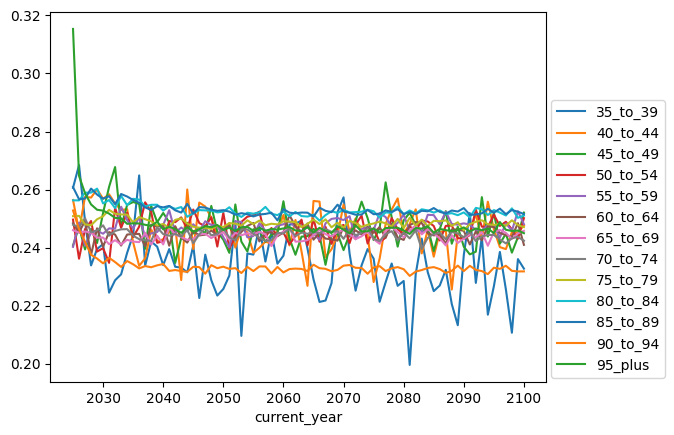

In [67]:
t = out_rates['alzheimers_mild_cognitive_impairment_state'].unstack()
t.loc['United_States_Of_America'].iloc[:,2:].plot()
plt.legend(loc=(1.01, .01));

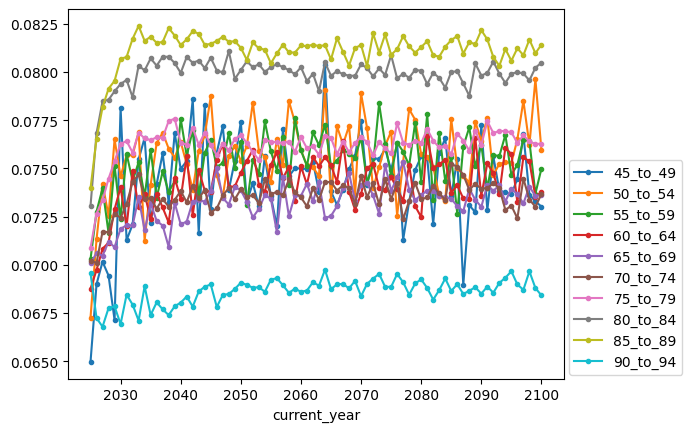

In [68]:
t = out_rates['alzheimers_blood_based_biomarker_state'].unstack()
t.loc['United_States_Of_America'].iloc[:,4:14].plot(marker='.')
plt.legend(loc=(1.01, .01));

In [69]:
# prevalence \approx incidence * duration
prevalence_count = person_time.groupby(['location', 'current_year', 'age_group', 'sub_entity']).value.sum().unstack()

mci_duration_est = (
    prevalence_count['alzheimers_mild_cognitive_impairment_state']
    / out_counts['alzheimers_blood_based_biomarker_state']
)
mci_duration_est

location                  current_year  age_group
United_States_Of_America  2025          25_to_29          inf
                                        30_to_34     9.052902
                                        35_to_39     7.292568
                                        40_to_44     8.134503
                                        45_to_49     9.016226
                                                       ...   
                          2100          75_to_79     6.864191
                                        80_to_84     6.563536
                                        85_to_89     6.534226
                                        90_to_94     7.877907
                                        95_plus      7.103145
Length: 1140, dtype: float64

In [70]:
new_sims = load_df('new_simulants').groupby(['location', 'current_year', 'age_group', ]).value.sum()
# new_sims


bbbm_duration_est = (
    prevalence_count['alzheimers_blood_based_biomarker_state']
    / new_sims
)
bbbm_duration_est

location                  current_year  age_group
United_States_Of_America  2025          25_to_29     0.210959
                                        30_to_34     6.877421
                                        35_to_39     2.439375
                                        40_to_44     1.595167
                                        45_to_49     3.430695
                                                       ...   
                          2100          75_to_79     3.367660
                                        80_to_84     3.733444
                                        85_to_89     3.344591
                                        90_to_94     1.528207
                                        95_plus      2.138667
Length: 1140, dtype: float64

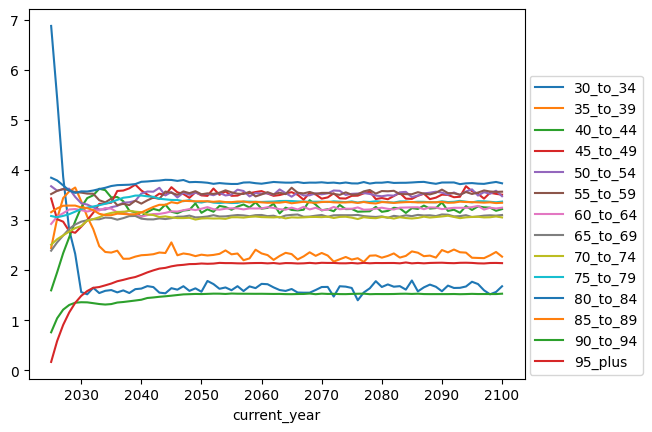

In [71]:
t = bbbm_duration_est.unstack()
t.loc['United_States_Of_America'].iloc[:, 1:].plot()
plt.legend(loc=(1.01, .01));

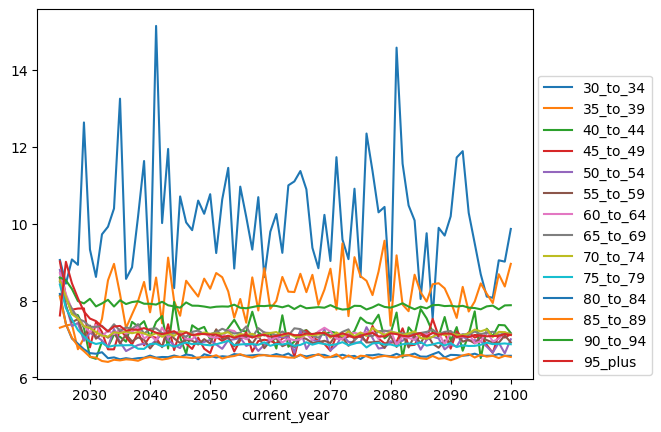

In [72]:
t = mci_duration_est.unstack()
t.loc['United_States_Of_America'].iloc[:, 1:].plot()
plt.legend(loc=(1.01, .01));

## Verify Other Cause Mortality in  Sim against artifact (ACMR - CSMR)

In [73]:
%%time

cols = ['input_draw','current_year','location','age_group','sex']

def calculate_ocmr():
    person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    total_pt = person_time_total.groupby(cols).sum(numeric_only=True)

    deaths = load_df('deaths')
    other_deaths = deaths[deaths.sub_entity == 'other_causes'].groupby(cols).sum(numeric_only=True)

    ocmr = (other_deaths / total_pt)[['value']].reset_index()

    ocmr2 = ocmr.merge(age_dictionary, on=['age_group'])
    ocmr3 = ocmr2.loc[ocmr2['age_group_id'].isin(age_group_ids)]
    ocmr4 = ocmr2.groupby([c for c in cols if c != 'input_draw'] + ['age_start']).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return ocmr4

sim_ocmr = calculate_ocmr()

CPU times: user 12.4 s, sys: 145 ms, total: 12.5 s
Wall time: 12.5 s


In [74]:
art_ocmr = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    
    # TODO: consider better ways to broadcast years from excess mx
    a = art.load(f'cause.all_causes.cause_specific_mortality_rate')
    b = art.load(f'cause.alzheimers_disease_and_other_dementias.cause_specific_mortality_rate')

    data1 = (a - b.droplevel(['year_start', 'year_end'])).dropna()
    data2 = (data1.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
            .filter(['mean', '2.5%', '97.5%']).reset_index())
    data3 = data2.merge(age_dictionary, on=['age_start','age_end'])
    data4 = data3.loc[data3['age_group_id'].isin(age_group_ids)]
    data4['measure'] = 'acmr'
    data4['location'] = locations[artifact_dirs.index(artifact_dir)].title()
    art_ocmr = pd.concat([art_ocmr, data4])
art_ocmr

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,age_group_id,age_group_name,age_group,measure,location
0,Female,30.0,35.0,2022,2023,0.000931,0.000911,0.000951,11,30 to 34,30_to_34,acmr,United_States_Of_America
1,Female,30.0,35.0,2023,2024,0.000898,0.000875,0.000925,11,30 to 34,30_to_34,acmr,United_States_Of_America
2,Female,30.0,35.0,2024,2025,0.000900,0.000871,0.000935,11,30 to 34,30_to_34,acmr,United_States_Of_America
3,Female,30.0,35.0,2025,2026,0.000901,0.000865,0.000942,11,30 to 34,30_to_34,acmr,United_States_Of_America
4,Female,30.0,35.0,2026,2027,0.000902,0.000856,0.000950,11,30 to 34,30_to_34,acmr,United_States_Of_America
...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,Male,95.0,125.0,2046,2047,0.255483,0.183408,0.309304,33,95 to 99,95_plus,acmr,United_States_Of_America
808,Male,95.0,125.0,2047,2048,0.255328,0.183463,0.309327,33,95 to 99,95_plus,acmr,United_States_Of_America
809,Male,95.0,125.0,2048,2049,0.255440,0.183938,0.309749,33,95 to 99,95_plus,acmr,United_States_Of_America
810,Male,95.0,125.0,2049,2050,0.255137,0.183684,0.310288,33,95 to 99,95_plus,acmr,United_States_Of_America


In [75]:
art_data = art_ocmr
location = 'United_States_Of_America'
sex='Female'
year=2030
# art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == year)]

In [77]:
def age_group_plot(measure, sim_data, art_data, art_year=None):
    for location in sim_data.location.unique():
        fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
        for i, year in enumerate([2030,2040,2050]):
            for j, sex in enumerate(sim_data.sex.unique()):
                color = f'C{j}'
                plot_data = sim_data.loc[(sim_data.location == location) & (sim_data.current_year == year) & (sim_data.sex == sex)]
                if art_year is None:
                    art_plot = art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == year)]
                else:
                    art_plot = art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == art_year)]

                ax[i].fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2, color=color)
                ax[i].fill_between(art_plot.age_start, art_plot['2.5%'], art_plot['97.5%'], alpha=0.2, color=color)

                ax[i].plot(art_plot.age_start, art_plot['mean'], linestyle='--', label=f'Artifact {sex}', color=color, linewidth=3)
                ax[i].plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {sex}', color=color)

                if i == 0:
                    ax[i].set_title(f"{measure} in {location}")

                ax[i].text(.5, .95, f"{year}", va='top', ha='center', transform=ax[i].transAxes)
#                 ax[i].tick_params(axis='x', labelrotation=90)
                
                if i == 2:
                    ax[i].set_xlabel("Age Group")
                    
                if i == 1:
                    ax[i].set_ylabel(f"{measure}")
                    ax[i].legend(loc=(1.01, 0))
#                 ax[i].semilogy()
        plt.subplots_adjust(hspace=0)


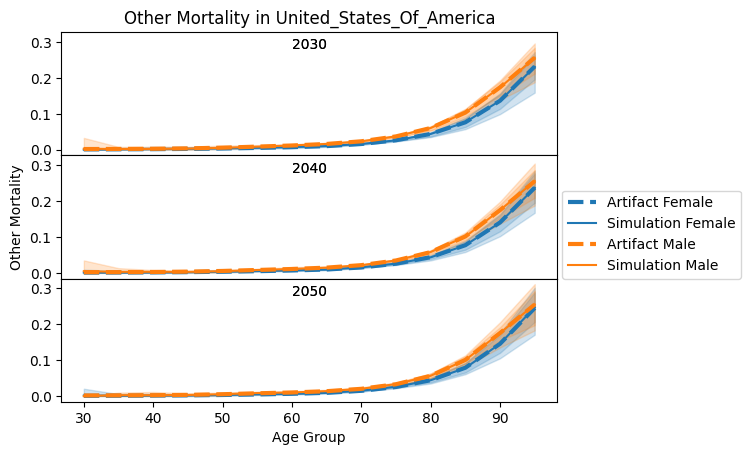

In [78]:
age_group_plot('Other Mortality', sim_ocmr, art_ocmr)

In [79]:
def over_time_plot(measure, sim_data, age_start):
    for location in sim_data.location.unique():
        for sex in sim_data.sex.unique():
            plot_data = sim_data.loc[(sim_data.location == location) & (sim_data.age_start == age_start) & (sim_data.sex == sex)]

            plt.plot(plot_data.current_year, plot_data['mean'], label=f'Simulation {sex}')
            plt.fill_between(plot_data.current_year, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

            plt.title(f"{measure} in {location} Over Time Among Age Start Group {age_start}")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Year")
            plt.ylabel(f"{measure}")
            plt.legend()
        plt.figure()

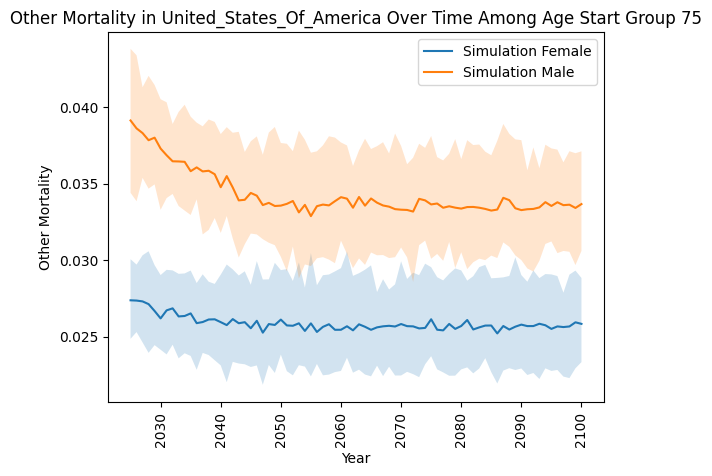

<Figure size 640x480 with 0 Axes>

In [80]:
over_time_plot('Other Mortality', sim_ocmr, 75)

## Validate Alzheimer’s EMR against GBD

In [81]:
cols = ['input_draw','current_year','location','age_group','sex']

def calculate_emr():
    person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    infected = person_time_total.loc[
        person_time_total.sub_entity == 'alzheimers_disease_state'
    ].groupby(cols).sum(numeric_only=True)
    assert len(infected) > 0

    deaths0 = load_df('deaths')
    deaths = deaths0.loc[
        deaths0.sub_entity == 'alzheimers_disease_state'
    ].groupby(cols).sum(numeric_only=True)
    assert len(deaths) > 0
    
    mr = (deaths / infected)[['value']].reset_index()

    mr = mr.merge(age_dictionary, on=['age_group'])
    mr = mr.loc[mr['age_group_id'].isin(age_group_ids)]
    mr1 = mr.groupby([c for c in cols if c != 'input_draw'] + ['age_start']
                    ).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return mr1

sim_emr = calculate_emr()

In [82]:
def load_artifact_cause_data(measure):
    out = pd.DataFrame()
    for artifact_dir in artifact_dirs:
        art = Artifact(artifact_dir, filter_terms = ['year_start==2021'])
        data = art.load(f'cause.alzheimers_disease_and_other_dementias.{measure}')
        data = (data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
                .filter(['mean', '2.5%', '97.5%']).reset_index())
        data = data.merge(age_dictionary, on=['age_start','age_end'])
        data = data.loc[data['age_group_id'].isin(age_group_ids)]
        data['measure'] = measure
        data['location'] = locations[artifact_dirs.index(artifact_dir)].title()
        out = pd.concat([out, data])
    return out

In [83]:
art_emr = load_artifact_cause_data('excess_mortality_rate')
# art_emr

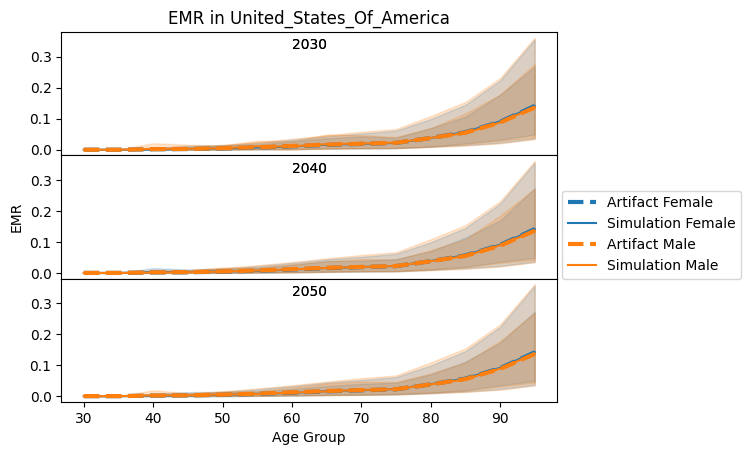

In [84]:
age_group_plot('EMR', sim_emr, art_emr, art_year=2021)

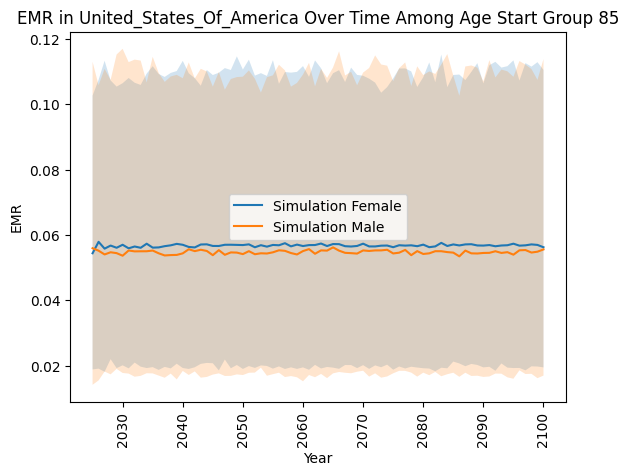

<Figure size 640x480 with 0 Axes>

In [85]:
over_time_plot('EMR', sim_emr, 85)

## Verify the number of new simulants per year against the AD population model

In [86]:
art_incidence_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load(
            'cause.alzheimers_disease_and_other_dementias.population_incidence_rate'
        ).droplevel(['year_start', 'year_end']),
        art.load('population.structure'),
        left_index=True,
        right_index=True,
        suffixes=['', '_pop']
    )
    art_incidence_data.append(df)
    
art_incidence_data = pd.concat(art_incidence_data)
for i in range(500):
    art_incidence_data[f'draw_{i}'] *= art_incidence_data[f'draw_{i}_pop']
    del art_incidence_data[f'draw_{i}_pop']
    

In [87]:
scale = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    temp = art.load('population.structure').reset_index() 
    temp['location'] = temp.location.str.replace(' ', '_').str.title()
    
    df_prev_pop = pd.merge(
        art.load('population.scaling_factor').query("year_start == 2021"),
        art.load('population.structure').query("year_start==2025").droplevel(['year_start', 'year_end']),
        left_index=True,
        right_index=True,
        suffixes=['_prev', '_pop']
    )
    prev = ((df_prev_pop.filter(like='draw_').filter(like='_prev')
            * df_prev_pop.filter(like='draw_').filter(like='_pop').values).mean(axis=1)).sum(axis=0)
    # TODO: use draw-specific scale instead of mean

    ratio = 100_000 / prev
    temp['ratio'] = ratio

    temp = temp.rename(columns={'year_start': 'current_year'})
    temp = temp.merge(age_dictionary, on=['age_start','age_end'])
    temp = temp.loc[temp['age_group_id'].isin(age_group_ids)]
    scale = pd.concat([scale, temp], ignore_index=True)
# scale

In [88]:
scale.groupby('location').ratio.describe()/5  # compare to 0.0035494897066482814 in interactive sim for USA

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
United_States_Of_America,168.0,0.001344,0.0,0.001344,0.001344,0.001344,0.001344,0.001344


In [89]:
cols = ['input_draw','current_year','location','age_group','sex']

new_sims = load_df('new_simulants')
# new_sims

In [90]:
trans = load_df('transition_count_alzheimers_disease_and_other_dementias')
new_ad_dementia = trans[trans.sub_entity == 'alzheimers_mild_cognitive_impairment_state_to_alzheimers_disease_state']

In [91]:
new_sims = new_sims.merge(scale[['location','sex','age_group','ratio','current_year']])
new_ad_dementia = new_ad_dementia.merge(scale[['location','sex','age_group','ratio','current_year']])

In [92]:
# new_sims

In [93]:
new_sims['total_incidence'] = new_sims['value'] / new_sims['ratio']
new_ad_dementia['total_incidence'] = new_ad_dementia['value'] / new_sims['ratio']

def summarize(df):
    df = df.groupby(cols).sum(numeric_only=True)
    df = df.groupby([c for c in cols if c != 'input_draw']).describe(percentiles=[0.025,0.975])['total_incidence'].reset_index()

    df = df.merge(age_dictionary, on=['age_group'])
    df = df.loc[df['age_group_id'].isin(age_group_ids)]

    return df

new_sims_summary = summarize(new_sims)

In [94]:
new_ad_dementia_summary = summarize(new_ad_dementia)
new_ad_dementia_summary

,current_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,age_group_id,age_group_name,age_start,age_end
0,2025,United_States_Of_America,30_to_34,Female,25.0,1927.897652,826.553052,297.515070,654.533153,1933.847953,3629.683851,4611.483581,11,30 to 34,30.0,35.0
1,2025,United_States_Of_America,30_to_34,Male,25.0,1505.426253,793.358024,297.515070,476.024112,1338.817814,3213.162753,3570.180837,11,30 to 34,30.0,35.0
2,2026,United_States_Of_America,30_to_34,Female,25.0,1213.861485,572.410541,148.757535,238.012056,1190.060279,2469.375079,2826.393162,11,30 to 34,30.0,35.0
3,2026,United_States_Of_America,30_to_34,Male,25.0,987.750032,507.885907,297.515070,386.769591,892.545209,2142.108502,2231.363023,11,30 to 34,30.0,35.0
4,2027,United_States_Of_America,30_to_34,Female,25.0,809.240990,468.605911,0.000000,89.254521,595.030139,1547.078363,1636.332884,11,30 to 34,30.0,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,2048,United_States_Of_America,95_plus,Male,25.0,197466.702083,63315.077120,98179.973012,110407.842378,187434.493931,324588.941078,424107.731903,33,95 to 99,95.0,125.0
724,2049,United_States_Of_America,95_plus,Female,25.0,311974.302121,90873.992240,139237.052635,166459.681515,316556.034195,496969.172481,593988.836720,33,95 to 99,95.0,125.0
725,2049,United_States_Of_America,95_plus,Male,25.0,198299.744278,65010.893185,98031.215477,115614.356098,183418.040490,328813.655068,430653.063437,33,95 to 99,95.0,125.0
726,2050,United_States_Of_America,95_plus,Female,25.0,309332.368302,90691.359016,141765.930727,170059.613859,310456.975266,497088.178509,597856.532627,33,95 to 99,95.0,125.0


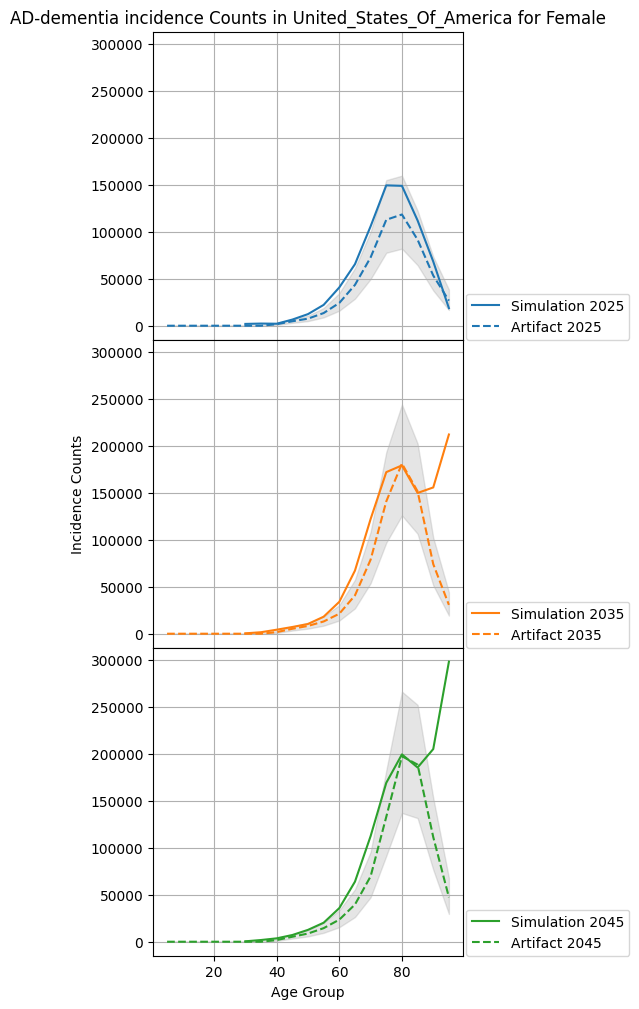

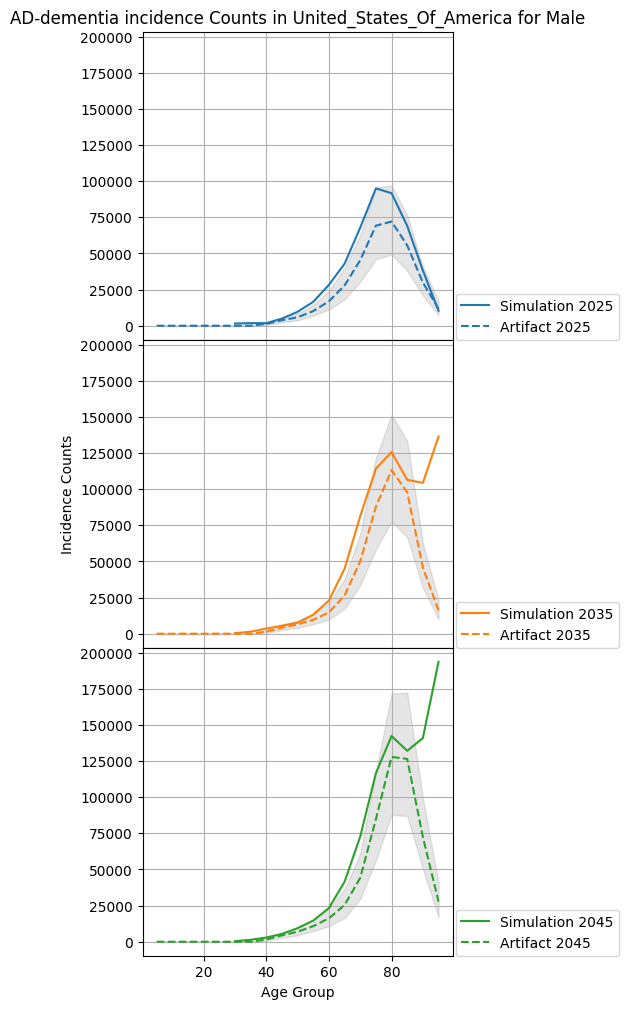

In [103]:
for location in new_sims.location.unique():
    for sex in new_sims.sex.unique():
        fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(4,12))
        plt.subplots_adjust(hspace=0)
        for i, year in enumerate([2025, 2035, 2045]):
            color = f'C{i}'
            plot_data = new_ad_dementia_summary.query('location == @location and current_year == @year and sex == @sex')

            location_w_spaces = location.replace('_', ' ').replace('Of', 'of')
            art_plot = art_incidence_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()

            art_plot['mean'] = art_plot.filter(like='draw_').mean(axis=1)
            art_plot['upper'] = np.percentile(art_plot.filter(like='draw_'), 97.5, axis=1)
            art_plot['lower'] = np.percentile(art_plot.filter(like='draw_'), 2.5, axis=1)

#             ax[i].fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2, color=color)
            ax[i].fill_between(art_plot.age_start, art_plot['upper'], art_plot['lower'], alpha=0.2, color='grey')
            ax[i].plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {year}', color=color)
            ax[i].plot(art_plot.age_start, art_plot['mean'], label=f'Artifact {year}', color=color, linestyle='--')
            ax[i].grid(True)
            if i == 0:
                ax[i].set_title(f"AD-dementia incidence Counts in {location} for {sex}")
#             plt.tick_params(axis='x', labelrotation=90)
            ax[i].set_xlabel("Age Group")
            if i == 1:
                ax[i].set_ylabel(f"Incidence Counts")
            ax[i].legend(loc=(1.01, 0))


## Verifying Prevalence

In [96]:
art_prev_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load(
            'population.scaling_factor'
                ).droplevel(['year_start', 'year_end']),
        art.load('population.structure'),
        left_index=True,
        right_index=True,
        suffixes=['', '_pop']
    )
    art_prev_data.append(df)
    
art_prev_data = pd.concat(art_prev_data)
for i in range(500):
    art_prev_data[f'draw_{i}'] *= art_prev_data[f'draw_{i}_pop']
    del art_prev_data[f'draw_{i}_pop']
art_prev_data

draw_0  \
sex    age_start age_end location                 year_start year_end                  
Female 5.0       10.0    United States of America 2021       2022           0.000000   
                                                  2022       2023           0.000000   
                                                  2023       2024           0.000000   
                                                  2024       2025           0.000000   
                                                  2025       2026           0.000000   
...                                                                              ...   
Male   95.0      125.0   United States of America 2046       2047      330970.674824   
                                                  2047       2048      339344.336022   
                                                  2048       2049      348031.186506   
                                                  2049       2050      356661.049969   
                                                  2050       2051      364673.050677   

                                                                              draw_1  \
sex    age_start age_end location                 year_start year_end                  
Female 5.0       10.0    United States of America 2021       2022           0.000000   
                                                  2022       2023           0.000000   
                                                  2023       2024           0.000000   
                                                  2024       2025           0.000000   
                                                  2025       2026           0.000000   
...                                                                              ...   
Male   95.0      125.0   United States of America 2046       2047      449015.564938   
                                                  2047       2048      461984.782189   
                                                  2048       2049      475835.555209   
                                                  2049       2050      489501.717735   
                                                  2050       2051      501778.237165   

                                                                             draw_10  \
sex    age_start age_end location                 year_start year_end                  
Female 5.0       10.0    United States of America 2021       2022           0.000000   
                                                  2022       2023           0.000000   
                                                  2023       2024           0.000000   
                                                  2024       2025           0.000000   
                                                  2025       2026           0.000000   
...                                                                              ...   
Male   95.0      125.0   United States of America 2046       2047      386755.658043   
                                                  2047       2048      401341.115741   
                                                  2048       2049      416637.287801   
                                                  2049       2050      431925.602486   
                                                  2050       2051      446511.536350   

                                                                            draw_100  \
sex    age_start age_end location                 year_start year_end                  
Female 5.0       10.0    United States of America 2021       2022           0.000000   
                                                  2022       2023           0.000000   
                                                  2023       2024           0.000000   
                                                  2024       2025           0.000000   
                                                  2025       2026           0.000000   
...                        

In [97]:
cols = ['input_draw','current_year','location','age_group','sex']

new_sims = load_df('person_time_alzheimers_disease_and_other_dementias')
new_sims = new_sims.merge(scale[['location','sex','age_group','ratio','current_year']])
new_sims['total_prev'] = new_sims['value'] / new_sims['ratio']
new_sims = new_sims.groupby(cols).sum(numeric_only=True)
new_sims = new_sims.groupby([c for c in cols if c != 'input_draw']).describe(percentiles=[0.025,0.975])['total_prev'].reset_index()

new_sims = new_sims.merge(age_dictionary, on=['age_group'])
new_sims = new_sims.loc[new_sims['age_group_id'].isin(age_group_ids)]
new_sims.tail()

,current_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,age_group_id,age_group_name,age_start,age_end
723,2048,United_States_Of_America,95_plus,Male,25.0,4.148146e+06,1.393821e+06,1.679642e+06,2.180717e+06,3.930493e+06,6.917164e+06,8.501510e+06,33,95 to 99,95.0,125.0
724,2049,United_States_Of_America,95_plus,Female,25.0,6.739126e+06,2.068274e+06,2.548977e+06,3.308215e+06,6.465831e+06,1.080213e+07,1.206106e+07,33,95 to 99,95.0,125.0
725,2049,United_States_Of_America,95_plus,Male,25.0,4.172434e+06,1.401873e+06,1.681281e+06,2.179316e+06,3.974168e+06,6.934485e+06,8.507919e+06,33,95 to 99,95.0,125.0
726,2050,United_States_Of_America,95_plus,Female,25.0,6.757210e+06,2.070990e+06,2.574765e+06,3.337625e+06,6.470824e+06,1.083962e+07,1.210280e+07,33,95 to 99,95.0,125.0
727,2050,United_States_Of_America,95_plus,Male,25.0,4.195530e+06,1.402491e+06,1.690747e+06,2.201124e+06,3.990863e+06,6.951836e+06,8.522006e+06,33,95 to 99,95.0,125.0


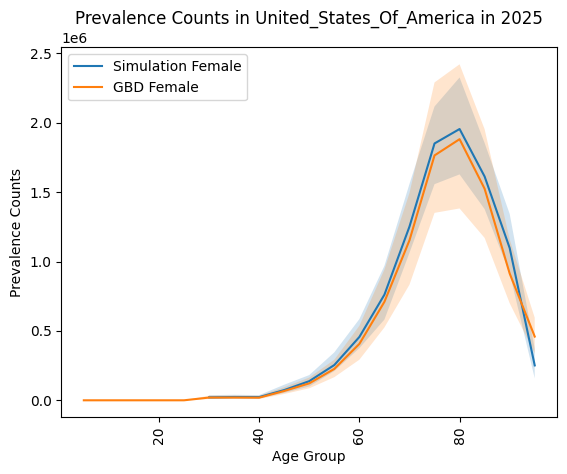

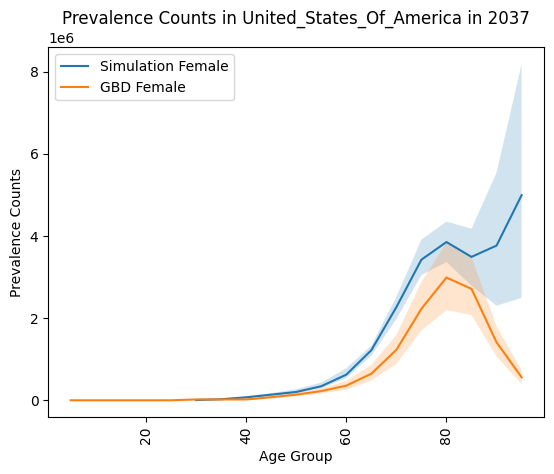

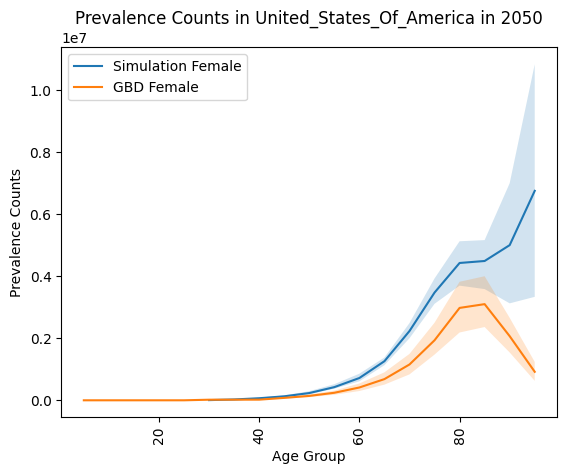

<Figure size 640x480 with 0 Axes>

In [98]:
for location in new_sims.location.unique():
    for year in [2025,2037,2050]:
        for sex in new_sims.sex.unique()[:1]:
            plot_data = new_sims.loc[(new_sims.location == location) & (new_sims.current_year == year) & (new_sims.sex == sex) ]
#             gbd_plot = gbd_data.loc[(gbd_data.location_name == location) & (gbd_data.sex == sex) & (gbd_data.measure == 'prevalence')]

            location_w_spaces = location.replace('_', ' ').replace('Of', 'of')
            art_plot = art_prev_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()
            art_plot['mean'] = art_plot.filter(like='draw_').mean(axis=1)
            art_plot['upper'] = np.percentile(art_plot.filter(like='draw_'), 97.5, axis=1)
            art_plot['lower'] = np.percentile(art_plot.filter(like='draw_'), 2.5, axis=1)

            plt.plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {sex}')
            plt.fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

            plt.plot(art_plot.age_start, art_plot['mean'], label=f'GBD {sex}')
            plt.fill_between(art_plot.age_start, art_plot['upper'], art_plot['lower'], alpha=0.2)

            plt.title(f"Prevalence Counts in {location} in {year}")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Age Group")
            plt.ylabel(f"Prevalence Counts")
            plt.legend()
        plt.figure()

## Total Sim Population Over Time

In [99]:
cols = ['input_draw','current_year','location'] #, 'age_group']

person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
person_time_total = person_time_total.groupby(cols)['value'].sum().reset_index()
person_time_total = person_time_total.groupby([c for c in cols if c != 'input_draw'])['value'].describe(percentiles=[0.025,0.975]).reset_index()
person_time_total#.head()

,current_year,location,count,mean,std,min,2.5%,50%,97.5%,max
0,2025,United_States_Of_America,25.0,105770.703244,1190.428116,103321.223819,103844.295688,105629.954825,108151.020945,109014.390144
1,2026,United_States_Of_America,25.0,126887.575524,5622.393297,115585.355236,117963.829158,126272.755647,137980.547023,142627.770021
2,2027,United_States_Of_America,25.0,145437.387433,9276.435802,126621.971253,130816.466530,144465.034908,163406.850103,170821.544148
3,2028,United_States_Of_America,25.0,162215.629076,12531.006421,136538.291581,142415.334702,160993.905544,186323.911294,196153.453799
4,2029,United_States_Of_America,25.0,177551.955975,15301.967134,145980.139630,153133.297741,176093.848049,206928.433676,218486.217659
...,...,...,...,...,...,...,...,...,...,...
71,2096,United_States_Of_America,25.0,330053.378891,43068.709717,243875.244353,260116.325257,326856.788501,403943.352772,423557.946612
72,2097,United_States_Of_America,25.0,330104.944559,43129.516892,243865.724846,260086.363860,327056.698152,404207.594251,423917.182752
73,2098,United_States_Of_America,25.0,330155.087310,43238.448050,243433.839836,259885.051335,326983.548255,404471.134292,423877.100616
74,2099,United_States_Of_America,25.0,330166.731170,43193.099269,243313.092402,259872.826283,327142.373717,404646.193018,423801.445585


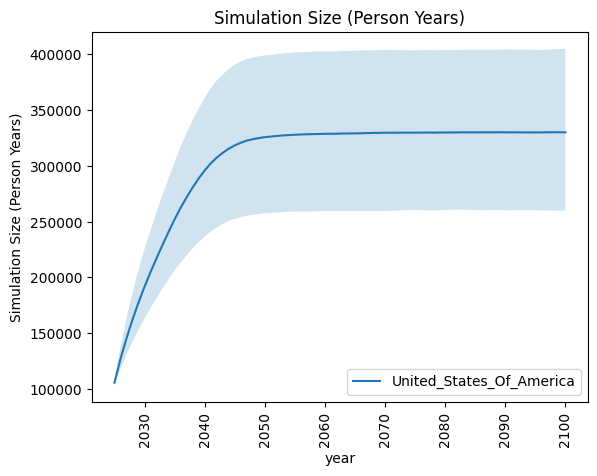

In [100]:
for location in person_time_total.location.unique():
    plot_data = person_time_total.loc[(person_time_total.location == location)]
    plt.plot(plot_data.current_year, plot_data['mean'], label=location)
    plt.fill_between(plot_data.current_year, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)
    plt.title(f"Simulation Size (Person Years)")
    plt.tick_params(axis='x', labelrotation=90)
    plt.xlabel("year")
    plt.ylabel("Simulation Size (Person Years)")
    plt.legend()